# Importation des librairies Python

In [1]:
import pandas as pd
import numpy as np
from time import time

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, label_binarize
from sklearn.decomposition import PCA, KernelPCA

import matplotlib.pyplot as plt
import collections
import scikitplot as skplt
import seaborn as sns

from google.cloud import bigquery

# Chargement des données depuis table BQ

In [2]:
client = bigquery.Client()                     #préparation du client pour interroger BigQuery et garder les data dans un pd.DataFrame

sql5 = """
WITH
  DMS AS (
  SELECT
    ROW_NUMBER() OVER(PARTITION BY date_pr__pa, Code_SAP ORDER BY FLAG_CF ASC) AS ROW,
    FLAG_CF,
    CAST(date_pr__pa AS DATE) AS DATE_PREPA,
    Code_SAP,
    Import_type,
    Usine,
    Base,
    Index_Pareto,
    Cause_Pareto
  FROM
    `electric-armor-213817.Archives_DMS.DMS_2019_07_30`
  GROUP BY
    FLAG_CF,
    date_pr__pa,
    Code_SAP,
    Usine,
    Import_type,
    Base,
    Index_Pareto,
    Cause_Pareto )
  #----------------------------------------------------------------------------
SELECT
  FLAG_CF,
  PREPARATION_DATE,
  PDT_COD,
  PDT_DSC,
IF
  (Forecast_table.Transformable = 'OUI',
    1,
    0) AS TRANSFORMABLE,
  IF(DATE_DIFF( PREPARATION_DATE,CAST(BDD_PDT.Product_launch_date AS DATE), MONTH) < 2 ,1,0) AS INNO,
  IF(Reft = '01 Afh', 1,0) AS IMPLUSE,
  BDD_PDT.Umbrella_Brand,
  DMS.Import_type,
  DMS.Usine,
  PLT_COD,
  PLT_DSC,
  SUM(Forecast_table.Forecast_including_adjustments) OVER(PARTITION BY Forecast_table.date, SAP_code ) AS PREVISION_NATIONAL,
  COMMANDE_NATIONAL,
  ALLOUE_NATIONAL,
  LIVRE_NATIONAL,
  (ALLOUE_NATIONAL - LIVRE_NATIONAL) AS ECART_ALLOC_NATIONAL,
  RUPTURE_NATIONAL,
  RUPTURE_STKA_NATIONAL,
IF
  (SUM(Forecast_table.Forecast_including_adjustments) OVER(PARTITION BY Forecast_table.date, SAP_code ) = 0,
    1,
    0) AS NO_FORECAST_NAT,
  COMMANDE_NATIONAL - SUM(Forecast_table.Forecast_including_adjustments) OVER(PARTITION BY Forecast_table.date, SAP_code ) AS ECART_PREVISION_NAT,
IF
  (SUM(Forecast_table.Forecast_including_adjustments) OVER(PARTITION BY Forecast_table.date, SAP_code ) = 0,
    90000,
    (SUM(Forecast_table.Forecast_including_adjustments) OVER(PARTITION BY Forecast_table.date, SAP_code ) - COMMANDE_NATIONAL)*100 / SUM(Forecast_table.Forecast_including_adjustments) OVER(PARTITION BY Forecast_table.date, SAP_code )) AS ECART_PREVISION_NAT_PERCENT,
  Forecast_table.Forecast_including_adjustments AS PREVISION,
  COMMANDE,
  ALLOUE,
  LIVRE,
  (ALLOUE - LIVRE) AS ECART_ALLOC,
  RUPTURE,
  RUPTURE_STKA,
IF
  (Forecast_table.Forecast_including_adjustments = 0,
    1,
    0) AS NO_FORECAST,
  COMMANDE - Forecast_table.Forecast_including_adjustments AS ECART_PREVISON,
IF
  (Forecast_table.Forecast_including_adjustments = 0,
    10000,
    (Forecast_table.Forecast_including_adjustments - COMMANDE)*100 / Forecast_table.Forecast_including_adjustments) AS ECART_PREVISION_PERCENT,
  CSL_ALLOC,
  CSL,
  CSL_ALLOC - CSL AS PERTE_CSL_vs_ALLOC,
  CSL_ALLOC_NATIONAL,
  CSL_NATIONAL,
  CSL_ALLOC_NATIONAL - CSL_NATIONAL AS PERTE_CSL_vs_ALLOC_NATIONAL,
  DMS.Cause_Pareto
FROM
  `electric-armor-213817.Archives_MicroStrategy.CSL_20181201_to_20190630_clean` AS MSTR_Archive_table,
  `electric-armor-213817.Data_Forecasts.Data_Forecasts_CAR` AS Forecast_table,
  `electric-armor-213817.Fichiers_produits.REFERENTIEL_PRODUITS_V2` AS BDD_PDT,
  DMS
WHERE
  MSTR_Archive_table.PREPARATION_DATE = Forecast_table.date
  AND MSTR_Archive_table.PLT_DSC = Forecast_table.DC
  AND MSTR_Archive_table.PDT_COD = Forecast_table.SAP_code
  AND MSTR_Archive_table.PDT_COD = BDD_PDT.Codification
  AND MSTR_Archive_table.PREPARATION_DATE = DMS.DATE_PREPA
  AND MSTR_Archive_table.PDT_COD = DMS.Code_SAP 
  AND IF(DMS.FLAG_CF = 0, TRUE, MSTR_Archive_table.PLT_DSC = DMS.Base)     #Condition sur quelle base joindre dans le cas ou j'ai une CF ou non (car top 10 donné sans la base)

"""

start_time = time()

df = client.query(sql5).to_dataframe()

print('Querying and loading time = {:0.2f} s \n'.format(time() - start_time))

df.head(3)

Querying and loading time = 11.58 s 



,FLAG_CF,PREPARATION_DATE,PDT_COD,PDT_DSC,TRANSFORMABLE,INNO,IMPLUSE,Umbrella_Brand,Import_type,Usine,...,NO_FORECAST,ECART_PREVISON,ECART_PREVISION_PERCENT,CSL_ALLOC,CSL,PERTE_CSL_vs_ALLOC,CSL_ALLOC_NATIONAL,CSL_NATIONAL,PERTE_CSL_vs_ALLOC_NATIONAL,Cause_Pareto
0,0,2019-01-02,122329,POT VERRE CITRUS x2 FR - AFH,0,0,1,DANONE,1,Aldaya(ES),...,0,-53,98.148148,100.0,100.0,0.0,55.223881,55.223881,0.0,Previsions
1,0,2019-01-02,122329,POT VERRE CITRUS x2 FR - AFH,0,0,1,DANONE,1,Aldaya(ES),...,0,-7,70.000000,100.0,100.0,0.0,55.223881,55.223881,0.0,Previsions
2,0,2019-01-02,122329,POT VERRE CITRUS x2 FR - AFH,0,0,1,DANONE,1,Aldaya(ES),...,0,22,-88.000000,100.0,100.0,0.0,55.223881,55.223881,0.0,Previsions


# Data Cleaning and Preprocessing

In [3]:
print(list(df))

['FLAG_CF', 'PREPARATION_DATE', 'PDT_COD', 'PDT_DSC', 'TRANSFORMABLE', 'INNO', 'IMPLUSE', 'Umbrella_Brand', 'Import_type', 'Usine', 'PLT_COD', 'PLT_DSC', 'PREVISION_NATIONAL', 'COMMANDE_NATIONAL', 'ALLOUE_NATIONAL', 'LIVRE_NATIONAL', 'ECART_ALLOC_NATIONAL', 'RUPTURE_NATIONAL', 'RUPTURE_STKA_NATIONAL', 'NO_FORECAST_NAT', 'ECART_PREVISION_NAT', 'ECART_PREVISION_NAT_PERCENT', 'PREVISION', 'COMMANDE', 'ALLOUE', 'LIVRE', 'ECART_ALLOC', 'RUPTURE', 'RUPTURE_STKA', 'NO_FORECAST', 'ECART_PREVISON', 'ECART_PREVISION_PERCENT', 'CSL_ALLOC', 'CSL', 'PERTE_CSL_vs_ALLOC', 'CSL_ALLOC_NATIONAL', 'CSL_NATIONAL', 'PERTE_CSL_vs_ALLOC_NATIONAL', 'Cause_Pareto']


In [4]:
#Regroupement de certaines causes dans la cause 'A Creuser'
df.loc[df['Cause_Pareto'] == 'Schéma', 'Cause_Pareto'] = 'A Creuser'
df.loc[df['Cause_Pareto'] == 'Expe usine', 'Cause_Pareto'] = 'A Creuser'



#Les causes des ruptures CF vont être biaisées car on a récupéré les quantités totales et pas uniquement les quantités de la commande ferme
#df = df[df['FLAG_CF'] == 0]

print('DataFrame Shape before deduplication = ',df.shape)

#Suppression des doublons
df = df.drop_duplicates(subset=['PREPARATION_DATE','PDT_COD','PLT_COD'], keep = 'first')             #On vire tous les doublons en regardant les colonnes 'date, SAP_code et DC' et on conserve uniquement la première occurence
df = df.dropna() 

print('DataFrame Shape after deduplication = ', df.shape)


#

DataFrame Shape before deduplication =  (4253, 39)
DataFrame Shape after deduplication =  (4143, 39)


**Tracé de la répartition des causes en fonction du type de commande (STD ou CF)**

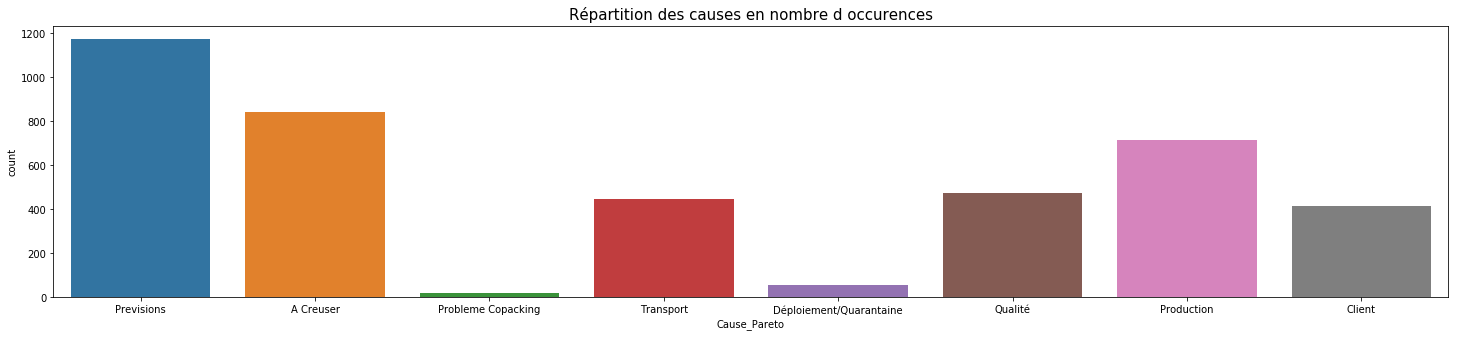

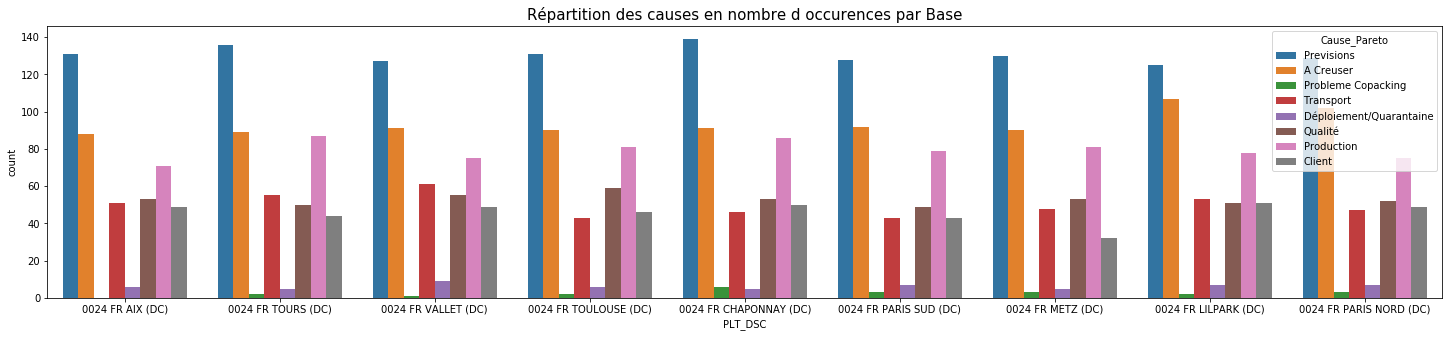

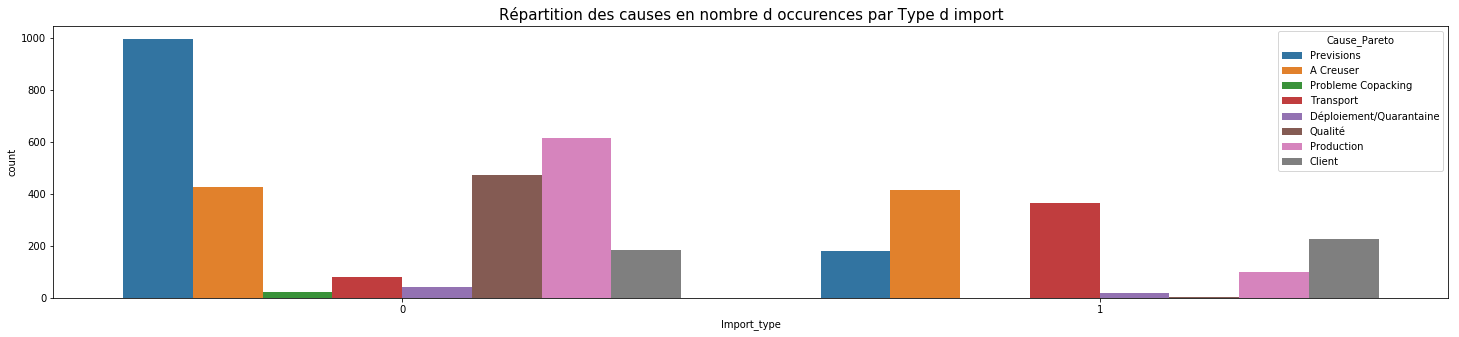

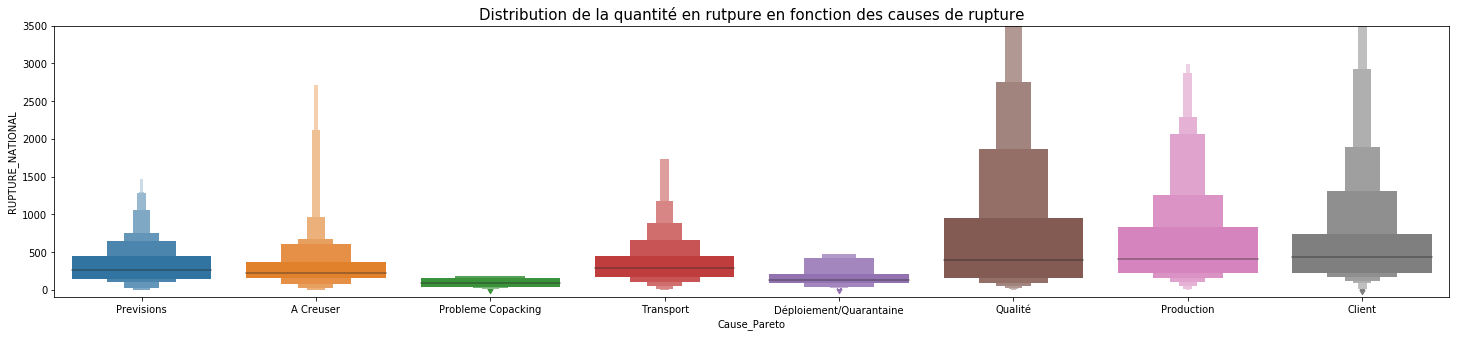

In [5]:
fig = plt.figure(figsize=(25,5))
plt.title('Répartition des causes en nombre d occurences', fontsize = 15)
sns.countplot(x = 'Cause_Pareto', data = df)

fig = plt.figure(figsize=(25,5))
plt.title('Répartition des causes en nombre d occurences par Base', fontsize = 15)
sns.countplot(x = 'PLT_DSC', hue = 'Cause_Pareto' , data = df)

fig = plt.figure(figsize=(25,5))
plt.title('Répartition des causes en nombre d occurences par Type d import', fontsize = 15)
sns.countplot(x = 'Import_type', hue = 'Cause_Pareto' , data = df)

fig = plt.figure(figsize=(25,5))
plt.ylim([-100, 3500])
plt.title('Distribution de la quantité en rutpure en fonction des causes de rupture', fontsize = 15)
sns.boxenplot(x = 'Cause_Pareto',y = 'RUPTURE_NATIONAL' , data = df)

## Corrélation des données

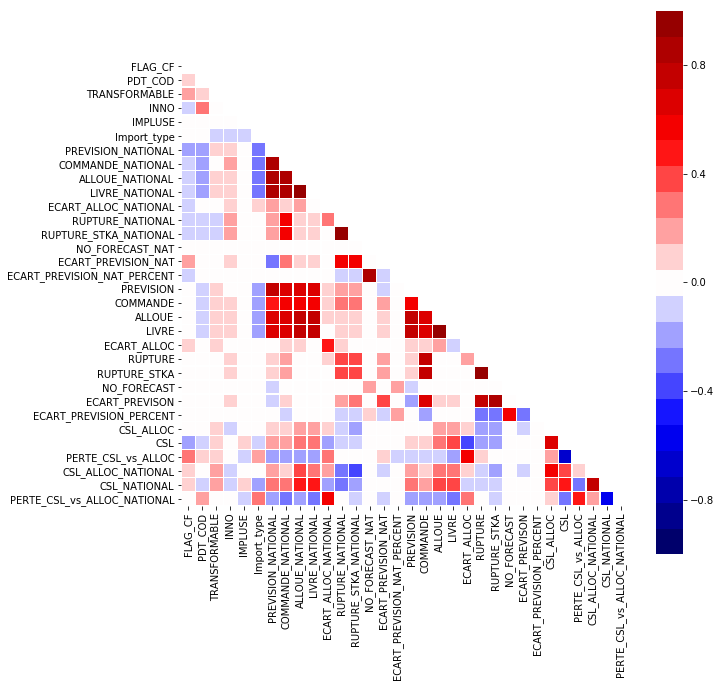

In [6]:
#Création d'un DataFrame pour faire l'analyse de correlation

data_corr = df.select_dtypes(exclude=['object'])    #On exclu tous les données catégoriques 
X_corr = data_corr.corr('pearson')
labels = X_corr.columns

#Maque pour n'afficher que la partie triangulaire inférieure de la matrice de correlation
mask = np.zeros_like(X_corr)
mask[np.triu_indices_from(mask)] = True

#plot heatmap
fig = plt.figure(figsize=(10,10))
sns.heatmap(X_corr, 
            linewidths=.2,
            mask = mask,
            square=True,
            cmap=sns.mpl_palette("seismic", 21),
            vmin=-1,
            vmax=1)

# RE-sampling des données pour limiter le déséquilibre des classes

In [7]:
#------------------- One Hot Encode of categorical data----------------------
data = df.drop(['PREPARATION_DATE', 'PLT_COD', 'PDT_COD', 'PDT_DSC'], axis = 1)

DC = pd.get_dummies(data.PLT_DSC)
PLANT = pd.get_dummies(data.Usine)
MARQUE = pd.get_dummies(data.Umbrella_Brand)

data = pd.concat([PLANT,DC,MARQUE,data], axis=1)
data = data.drop(['PLT_DSC','Usine','Umbrella_Brand'], axis=1) 


#---------------------- Verification des lignes avec des NULLs--------------------
data.isnull().any().any()


#Etape obligatoire car les modèles ne prennent pas directement les DataFrame ==> Besoin de convertir en ndarray
X = data.iloc[:, :-1].values    #Features
y = data.iloc[:,-1].values      #Labels 

feature_names = list(data)[:-1]
class_names = np.unique(y)

print(class_names)

['A Creuser' 'Client' 'Déploiement/Quarantaine' 'Previsions'
 'Probleme Copacking' 'Production' 'Qualité' 'Transport']


In [18]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

populaire = [list(elem) for elem in collections.Counter(y).most_common()]
max_occurence = int(populaire[0][1])
populaire = pd.DataFrame(columns = ['Class_Name', 'Original_Number'], data = populaire)

max_percent = 0.5

dict_over = {
             'Transport': int(max_occurence*(max_percent-0.02)), 
 #            'Client': int(max_occurence*(max_percent)), 
             'Déploiement/Quarantaine': int(max_occurence*(max_percent-0.25)), 
             'Probleme Copacking': int(max_occurence*(max_percent-0.3)),
             'Production': int(max_occurence*(max_percent+0.2)),
             'Qualité': int(max_occurence*(max_percent+0.05)),
#             'Schéma': int(max_occurence*(max_percent-0.25)),
#             'Expe usine': int(max_occurence*(max_percent-0.3))
            }       #Je crée un dictionnaire ou je lui dit combien de sample je veux par classe 

dict_under = {
#             'A Creuser': int(max_occurence*0.8),
#             'Previsions': int(max_occurence*0.65)
             }

smote = SMOTE(sampling_strategy=dict_over,  k_neighbors=3)
under_sampler = RandomUnderSampler(sampling_strategy = dict_under )

X_SMOTE , y_SMOTE = smote.fit_sample(X,y)
X_SMOTE , y_SMOTE = under_sampler.fit_sample(X_SMOTE , y_SMOTE)

populaire_over_sampled = [list(elem) for elem in collections.Counter(y_SMOTE).most_common()]
populaire_over_sampled = pd.DataFrame(columns = ['Class_Name', 'Number_after_Over-sampling'], data = populaire_over_sampled)


Comparaison_oversampling = populaire.set_index('Class_Name').join(populaire_over_sampled.set_index('Class_Name'))
Comparaison_oversampling['Samples_Created'] = Comparaison_oversampling['Number_after_Over-sampling'] - Comparaison_oversampling['Original_Number']
Comparaison_oversampling['Initial Unbalance_ratio'] = Comparaison_oversampling['Original_Number'] / Comparaison_oversampling['Original_Number'].min()
Comparaison_oversampling['Final Unbalance_ratio'] = Comparaison_oversampling['Number_after_Over-sampling'] / Comparaison_oversampling['Number_after_Over-sampling'].min()


Comparaison_oversampling


,Original_Number,Number_after_Over-sampling,Samples_Created,Initial Unbalance_ratio,Final Unbalance_ratio
Class_Name,,,,,
Previsions,1176,1176,0,53.454545,5.004255
A Creuser,840,840,0,38.181818,3.574468
Production,713,823,110,32.409091,3.502128
Qualité,475,646,171,21.590909,2.748936
Transport,447,564,117,20.318182,2.400000
Client,413,413,0,18.772727,1.757447
Déploiement/Quarantaine,57,294,237,2.590909,1.251064
Probleme Copacking,22,235,213,1.000000,1.000000


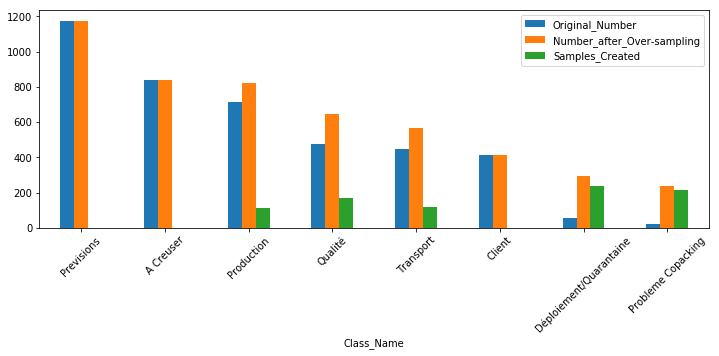

In [19]:
Comparaison_oversampling.plot.bar(y = list(Comparaison_oversampling.columns)[:-2], 
                                  figsize = (12,4), 
                                  rot = 45)